In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import v2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import math

In [2]:
import os
import sys

train_path, validation_path, test_path = "", "", ""

# Function to detect the environment
def detect_environment():
    # Check if Google Colab
    try:
        import google.colab
        return 'colab'
    except ImportError:
        pass
    
    # Check if Jupyter Notebook
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return 'jupyter'
        elif shell == 'TerminalInteractiveShell':
            return 'terminal'
        else:
            return 'other'
    except NameError:
        return 'other'

# Set paths based on the detected environment
env = detect_environment()

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    
    train_path = "/content/drive/MyDrive/fullset_train.csv"
    validation_path = "/content/drive/MyDrive/fullset_validation.csv"
    test_path = "/content/drive/MyDrive/fullset_test.csv"
elif env == 'jupyter':
    # supposed on GitHub
    train_path = "../Dataset/fullset_train.csv"
    validation_path = "../Dataset/fullset_validation.csv"
    test_path = "../Dataset/fullset_test.csv"
else:
    print("Unknown environment. Please set paths manually.")

# Use the DATA_PATH in your code
if train_path:
    print(f"train path is set to: {train_path}")
else:
    print("train_path is not set. Please check your environment settings.")


train path is set to: ../Dataset/fullset_train.csv


In [3]:
# device detection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [4]:
# HYPERPARAMETERS
n_bases = 4

isWeighted = True
pos_weights_ratio = 1
batch_size = 256
learning_rate = 1e-3
n_epochs = 30

loss_info_ratio = 1

In [5]:
# GPU version (immediately moves the data on GPU to enanche performaces)
def convert_string_sequence_into_array(sequence):
    result = np.zeros(shape=(1, n_bases, len(sequence)))
    base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    for idx, base in enumerate(sequence.upper()):
        result[0, base_dict[base], idx] = 1
    return result

class DNADatasetForGPU(Dataset):

    def __init__(self, csv_path):
        df = pd.read_csv(csv_path, header=0, names=['seq_id', 'sequence', 'label'])

        self.y = torch.tensor(df['label'].values).float().view(-1, 1).to(device)
        self.x = torch.tensor(
            np.array([convert_string_sequence_into_array(seq) for seq in df['sequence']])
        ).float().to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
# DATASET EXTRACTION
train_dataset = DNADatasetForGPU(train_path)

val_dataset = DNADatasetForGPU(validation_path)

test_dataset = DNADatasetForGPU(test_path)

print(len(train_dataset), len(val_dataset), len(test_dataset))

# calculating the ratio between the classes
if isWeighted:
    n_pos_examples = (train_dataset.y == 1).sum().item()
    n_neg_examples = len(train_dataset) - n_pos_examples
    pos_weight = n_neg_examples / float(n_pos_examples)
    
    pos_weight_tensor = torch.tensor([pos_weights_ratio * pos_weight]).to(device)

    print("pos_weight:", pos_weight_tensor.item())
    print("pos_weight tensor size:", pos_weight_tensor.shape)

211238 26404 26404
pos_weight: 46.29914855957031
pos_weight tensor size: torch.Size([1])


In [7]:
# Dataloader declarations
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        attention_weights = torch.softmax(self.attention(x).squeeze(-1), dim=-1)
        return torch.sum(x * attention_weights.unsqueeze(-1), dim=1)
        
class EnhancedVirusModel2(nn.Module):
    def __init__(self, maps=64, hidden=32):
        super(EnhancedVirusModel2, self).__init__()
        self.maps = maps
        
        self.conv = nn.Conv2d(1, maps, kernel_size=(4, 5))
        self.batch_norm = nn.BatchNorm2d(maps)
        self.relu = nn.ReLU()
        self.max = nn.MaxPool2d(kernel_size=(1, 2))
        self.lstm = nn.LSTM(maps, hidden, bidirectional=True, batch_first=True)
        self.attention = AttentionBlock(hidden*2, hidden)
        self.fc = nn.Linear(hidden*2, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        #x = x.view(x.size(0), x.size(2), x.size(3))
        #x = torch.transpose(x, -1, -2)
        x = self.relu(self.batch_norm(self.conv(x)))
        x = self.max(x)
        x = self.dropout(x)
        
        # size [batch_size, self.maps, 1, 147] into [batch_size, 147, self.maps]
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        x, _ = self.lstm(x)
        x = self.attention(x)
        x = self.dropout(x)
        return self.fc(x)

In [9]:
model = EnhancedVirusModel2(maps=128, hidden=64).to(device)

In [10]:
model.load_state_dict(torch.load('../Models/EVM2_cyclicRate_1conv_Xavier.pth'))

C:\Users\Matteo Ruta\AppData\Local\Temp\ipykernel_21724\224911122.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../Models/EVM2_cyclic

<All keys matched successfully>

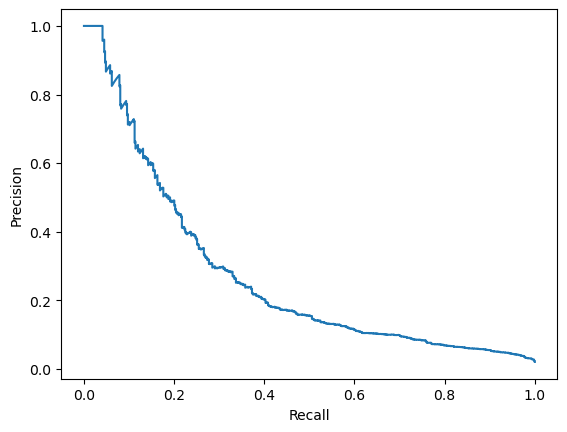

In [11]:
# computing ROC curve using sklearn.metrics
# with this implementation, we repeat the same validation_loop we did in the last epoch
# maybe this thing could be done better
model.eval()
ground_truth = val_dataset.y.cpu().numpy()
pred_probabilities = []
#pred_probabilities = torch.Tensor.numpy(nn.Sigmoid()(model(validation_dataset.features)).cpu())

with torch.no_grad():
    for X, y in val_dataloader:
        #X = X.to(device)
        #y = y.to(device)
        
        y_pred = model(X)
        prob_pred = nn.functional.sigmoid(y_pred)

        pred_probabilities.extend(prob_pred.cpu().numpy())

pred_probabilities = np.array(pred_probabilities)

precision, recall, pr_thresholds = precision_recall_curve(ground_truth, pred_probabilities)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [15]:
selected_precision = 0.6
target = np.argmin(abs(precision - selected_precision))
threshold = pr_thresholds[target]
print("Selected threshold:", threshold)

Selected threshold: 0.9273868


C:\Users\Matteo Ruta\AppData\Local\Temp\ipykernel_17152\3620657524.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Predicted Positive', 'Predicted Negative'])
C:\Users\Matteo Ruta\AppData\Local\Temp\ipykernel_17152\3620657524.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Actual Positive', 'Actual Negative'])


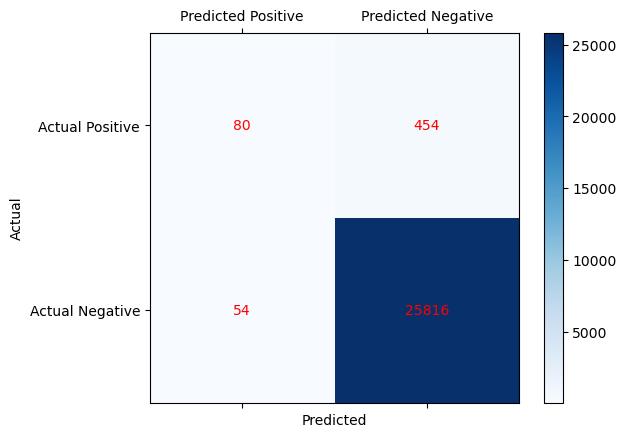

In [16]:
cm = confusion_matrix(ground_truth, (pred_probabilities > threshold).astype(int))
# cm shape
# [[TN, FP]
#  [FN, TP]]
cm = np.flip(cm)

# Plotting the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Annotate the matrix with the counts
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

# Set labels
ax.set_xticklabels([''] + ['Predicted Positive', 'Predicted Negative'])
ax.set_yticklabels([''] + ['Actual Positive', 'Actual Negative'])

# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show plot
plt.show()